# Supplementary Figures

In [3]:
setwd("~/Dropbox/OMP\ shared/peter_wu/1st_paper_nichols_reanalysis/github/Systematic-analyses-ecoli-phenotypes/Nichols_data_mining_code")
source("Nichols_preload.R")
df=strain1strain2_allAnnotations_allSimilarities
df$abs_pcc=abs(df$pcc)

# Figure S3

In [2]:
auxotroph_1=read_excel("Data/No_growth_on_MOPS_Glu_0.4%.xlsx",sheet=1)
auxotroph_2=read_excel("Data/No_growth_on_MOPS_Glu_0.4%.xlsx",sheet=2)
auxotroph=dplyr::full_join(auxotroph_1,auxotroph_2,by=c("Gene name","EcoCyc ID","ECK number"))

names(auxotroph)=c("associated_gene_names","EcoCycID","bNumber","ECK")
used_strain_table=left_join(auxotroph,id_allAttributes[,
                                                       c("ids","associated_gene_names","EcoCycID","bNumber","ECK")] %>% unique,
                            by=names(auxotroph))


##dim(used_strain_table) #hisA was duplicated (Fine. In Nichols there are duplicated strains for hisA)

not_used_id=used_strain_table$ids %>% unique
not_used_id=not_used_id[!is.na(not_used_id)]
not_used_id=as.numeric(not_used_id)




#with minimal media
cor_matrix=cor(t(All_Data_NAimputed[setdiff(1:3979,not_used_id),])) 
cor_matrix[is.na(cor_matrix)]=-9 #change where cor=NA to -9 
dist_=as.dist(cor_matrix)
new_cor_table=meltANDsort_dist(dist_)
new_cor_table=new_cor_table[!(new_cor_table[,3]==-9),] 
new_cor_table$object_1=as.numeric(new_cor_table$object_1)
new_cor_table$object_2=as.numeric(new_cor_table$object_2)
new_cor_table[,3]=abs(new_cor_table[,3]) 
names(new_cor_table)=c("strain1","strain2","pcc")
table_1=left_join(new_cor_table,strain1strain2_allAnnotations_allSimilarities[,c(1:7,9:12)],by=c("strain1","strain2"))
table_1$abs_pcc=abs(table_1$pcc)


#without minimal media
load("Data/uniqueChemIndex.RData")
TF=( names(uniqueChemIndex) %in% c("NH4Cl (MOPS)","Iron excess-FeSO4","Iron starvation-FeSO4","Acetate (M9)",
                                   "Glucosamine (M9)","Glucose (M9)","Glycerol (M9)","Maltose (M9)","N-acetyl Glucosamine","Succinate (M9)") )
used_cond=names(uniqueChemIndex)[!TF]
cond_indices=unlist(uniqueChemIndex[used_cond])

cor_matrix=cor(t(All_Data_NAimputed[setdiff(1:3979,not_used_id),cond_indices])) 
cor_matrix[is.na(cor_matrix)]=-9 #change where cor=NA to -9 
dist_=as.dist(cor_matrix)
new_cor_table=meltANDsort_dist(dist_)
new_cor_table=new_cor_table[!(new_cor_table[,3]==-9),] 
new_cor_table$object_1=as.numeric(new_cor_table$object_1)
new_cor_table$object_2=as.numeric(new_cor_table$object_2)
new_cor_table[,3]=abs(new_cor_table[,3]) 
names(new_cor_table)=c("strain1","strain2","pcc")
table_2=left_join(new_cor_table,strain1strain2_allAnnotations_allSimilarities[,c(1:7,9:12)],by=c("strain1","strain2"))
table_2$abs_pcc=abs(table_2$pcc)

In [4]:
get_confusionMatrix=function(df,annot,similarity,seed=9){   
  
  if(length(similarity)!=dim(df)[1]){ #if new similarity is in the the table, just retreive from the table
    similarity=df[,similarity]
    }
  df=cbind(df[,annot],similarity)
  
  if(length(annot)>=2){
    coannotation=(rowSums(df[,annot])>=1)
    #coannotation=(rowSums(df[,annot])>=length(annot)) this is A&B&...
    cumsum_=cumsum(coannotation[order(df[,dim(df)[2]],decreasing=T)])
    return(confusionMatrix_metrics(cumsum_,seed=seed))
  } 
  
  cumsum_=cumsum(df[,1][order(df[,2],decreasing=T)])
  return(confusionMatrix_metrics(cumsum_,seed=seed))
}

graph_corr_annot=function(metric,similarity,samples,subset,cols,ylim,xlim,lwd,annot_list,annot_list_name,seed=103){    
    
options(repr.plot.width = 10, repr.plot.height = 7)    
first=T
    
for(similarity_ in similarity){
    
    for(metric_ in metric){
        
        random_metric=paste0("random_",metric_)
        for(j in seq(annot_list)){
  
          #precalculate and subset to prevent memory problem
          con1=get_confusionMatrix(df=table_1,annot_list[[j]],similarity_,seed=seed)[1:subset,]
          con2=get_confusionMatrix(df=table_2,annot_list[[j]],similarity_,seed=seed)[1:subset,]


          exp_list=list(con1,con2)
          exp_1_name="- auxotrophs / + minimal media"
          exp_2_name="- auxotrophs / - minimal media"
          names(exp_list)=c(exp_1_name,exp_2_name)



          for(i in seq(exp_list)){
            if(i==1){
                                                  
              plot(samples,exp_list[[i]][[metric_]][samples],xlab="",ylab="",type='l',col=cols[i],
                   ylim=ylim,xlim=xlim,lwd = lwd,main=paste0("Same ",paste(annot_list_name[j],collapse=" "))) 
              grid(lty='solid')

                
            }else{
              lines(samples,exp_list[[i]][[metric_]][samples],col=cols[i],lwd = lwd) 
            }


          }

          legend(150, 1.04, legend=names(exp_list),
                 col=cols, lty=1,lwd = lwd, cex=1, box.lty=0) 

          #add the negative control
          lines(samples,exp_list[[1]][[random_metric]][samples],col='black',lty = 'dashed',lwd=2.5)
  
}
}


  } 
}    

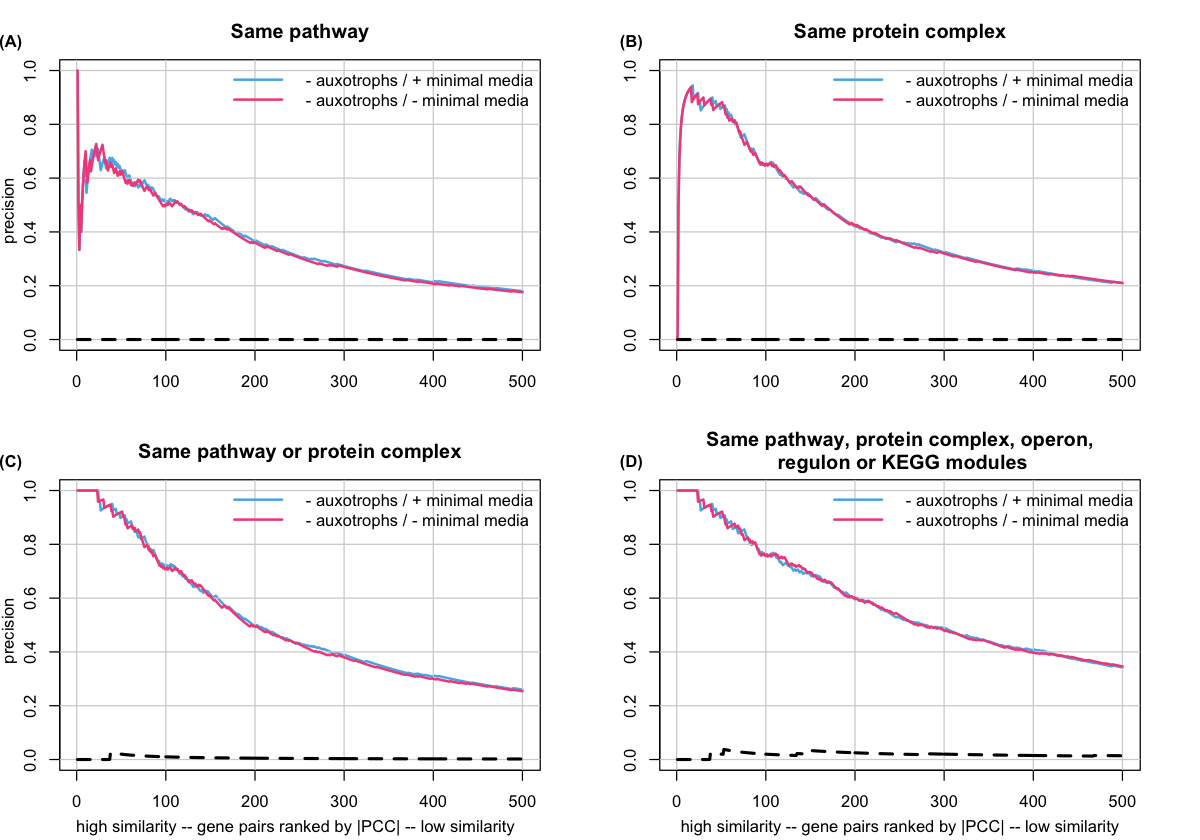

In [5]:
##compare: pwy - pwy with no minimum media, ptcomplex...., any annotation

##iterate through all parameters

#This uses the same combination of annotations as the violin plots
metric="precision" #this is a highly imbalanced dataset so I will not use accuracy or specificity
similarity="abs_pcc"
samples=1:500
subset=500
cols=c("#56B4E9","#F3518A")
y=metric
ylim=c(0,1)
xlim=c(1,max(samples))
lwd=2
annot_list=list("pwy","pcomplex",c("pwy","pcomplex"),c("pwy","pcomplex","operon","regulon","kegg_modules"))
annot_list_name=c("pathway","protein complex",
                  "pathway or protein complex",
                  "pathway, protein complex, operon,\n regulon or KEGG modules"
                 )

par(mfrow=c(2,2),mar=c(3.5,3,3,3),oma=c(0,0,0,0))
graph_corr_annot(metric,similarity,samples,subset,cols,ylim,xlim,lwd,annot_list,annot_list_name,seed=123)

## add x and y-axis (https://stackoverflow.com/questions/11198767/how-to-annotate-across-or-between-plots-in-multi-plot-panels-in-r)
text(grconvertX(.087, "ndc", "user"), grconvertY(.75, "ndc", "user"), "precision", srt=90, xpd=NA)
text(grconvertX(.087, "ndc", "user"), grconvertY(.25, "ndc", "user"), "precision", srt=90, xpd=NA)
text(grconvertX(0.3, "ndc", "user"), grconvertY(0.015, "ndc", "user"), "high similarity -- gene pairs ranked by |PCC| -- low similarity", xpd=NA)
text(grconvertX(0.75, "ndc", "user"), grconvertY(0.015, "ndc", "user"), "high similarity -- gene pairs ranked by |PCC| -- low similarity", xpd=NA)

# add (A), (B), (C), (D)
text(grconvertX(.088, "ndc", "user"), grconvertY(0.95, "ndc", "user"), "(A)", xpd=NA,font=2)
text(grconvertX(.55, "ndc", "user"), grconvertY(0.95, "ndc", "user"), "(B)", xpd=NA,font=2)
text(grconvertX(.088, "ndc", "user"), grconvertY(0.45, "ndc", "user"), "(C)", xpd=NA,font=2)
text(grconvertX(.55, "ndc", "user"), grconvertY(0.45, "ndc", "user"), "(D)", xpd=NA,font=2)

# Figure S4

In [6]:
#functions to get confusion matrix based on annot and similarity
get_confusionMatrix=function(table_,annot,similarity,seed=9){   
    df=table_[,c(annot,similarity)]
        if(length(annot)>=2){
            coannotation=(rowSums(df[,annot])>=1)
            #coannotation=(rowSums(df[,annot])>=length(annot)) this is A&B&...
            cumsum_=cumsum(coannotation[order(df[,similarity],decreasing=T)])
            return(confusionMatrix_metrics(cumsum_,seed=seed))
        } 
    
    cumsum_=cumsum(df[,annot][order(df[,similarity],decreasing=T)])
    return(confusionMatrix_metrics(cumsum_,seed=seed))
}

In [7]:
#This gets precison using the same combination of annotations as the violin plots
subset=500

#precalculate and subset to prevent memory problem
con1=get_confusionMatrix(table_1,c("pwy","pcomplex","operon","regulon","kegg_modules"),"pcc",seed=1009)[1:subset,]
con2=get_confusionMatrix(table_1,c("pwy","pcomplex","operon","regulon","kegg_modules"),"mi",seed=1009)[1:subset,]
con3=get_confusionMatrix(table_1,c("pwy","pcomplex","operon","regulon","kegg_modules"),"spearman",seed=1009)[1:subset,]

annot_list=list(con1,con2,con3)
names(annot_list)=c("PCC","MI","Spearman")

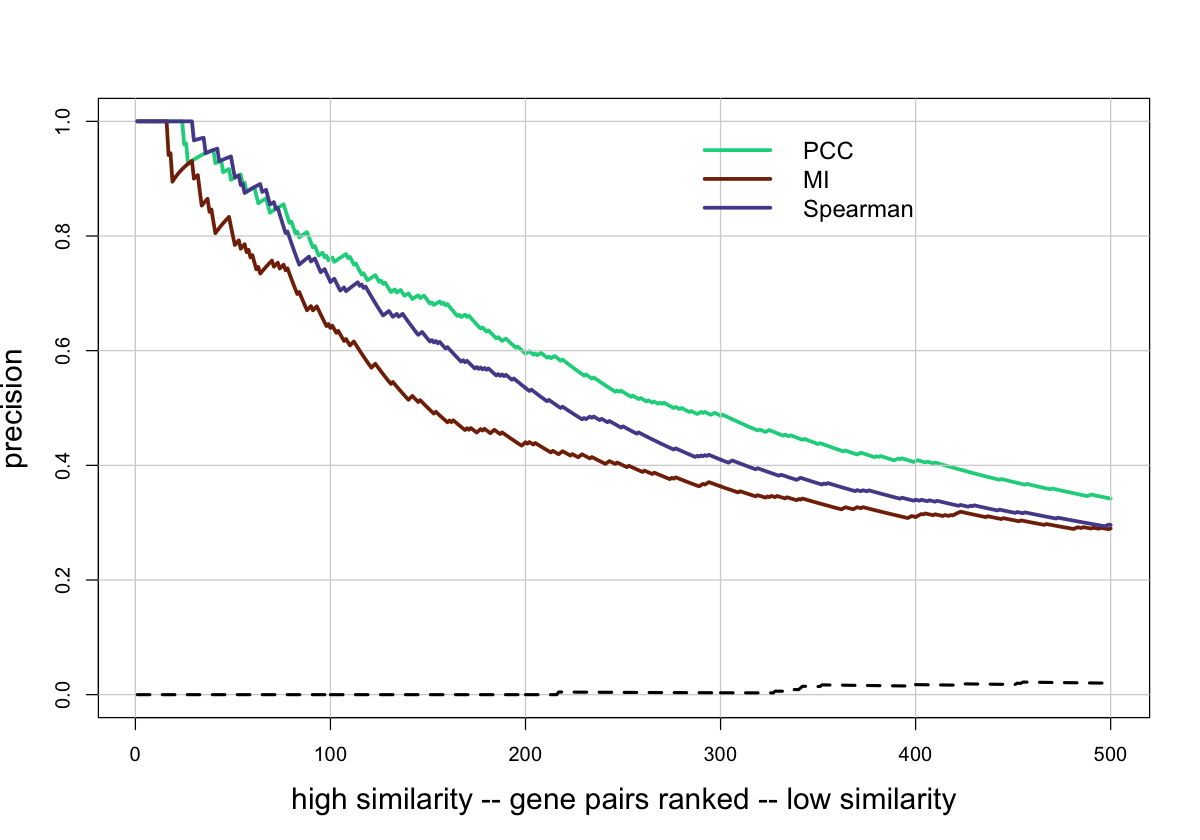

In [8]:
samples=1:500
cols=c("#09D38A","#832B05","#564c99")
metric="precision"
random_metric=paste0("random_",metric)
x_lab="high similarity -- gene pairs ranked -- low similarity"
y=metric
ylim=c(0,1)
xlim=c(1,max(samples))
lwd=3

options(repr.plot.width = 10, repr.plot.height = 7)


for(i in seq(annot_list)){
    if(i==1){
      plot(samples,annot_list[[i]][[metric]][samples],xlab=x_lab,ylab=metric,type='l',col=cols[i],
           ylim=ylim,xlim=xlim,lwd = lwd, cex.lab=1.5) 
    grid(lty='solid')
    }else{
      lines(samples,annot_list[[i]][[metric]][samples],xlab=x_lab,ylab=metric,col=cols[i],lwd = lwd) 
    }
}


legend(275, 1, legend=names(annot_list),
       col=cols, lty=1,lwd = lwd, cex=1.2, box.lty=0) 

#add the negative control
lines(samples,annot_list[[1]][[random_metric]][samples],col='black',lty = 'dashed',lwd=2.5)

# Figure S5

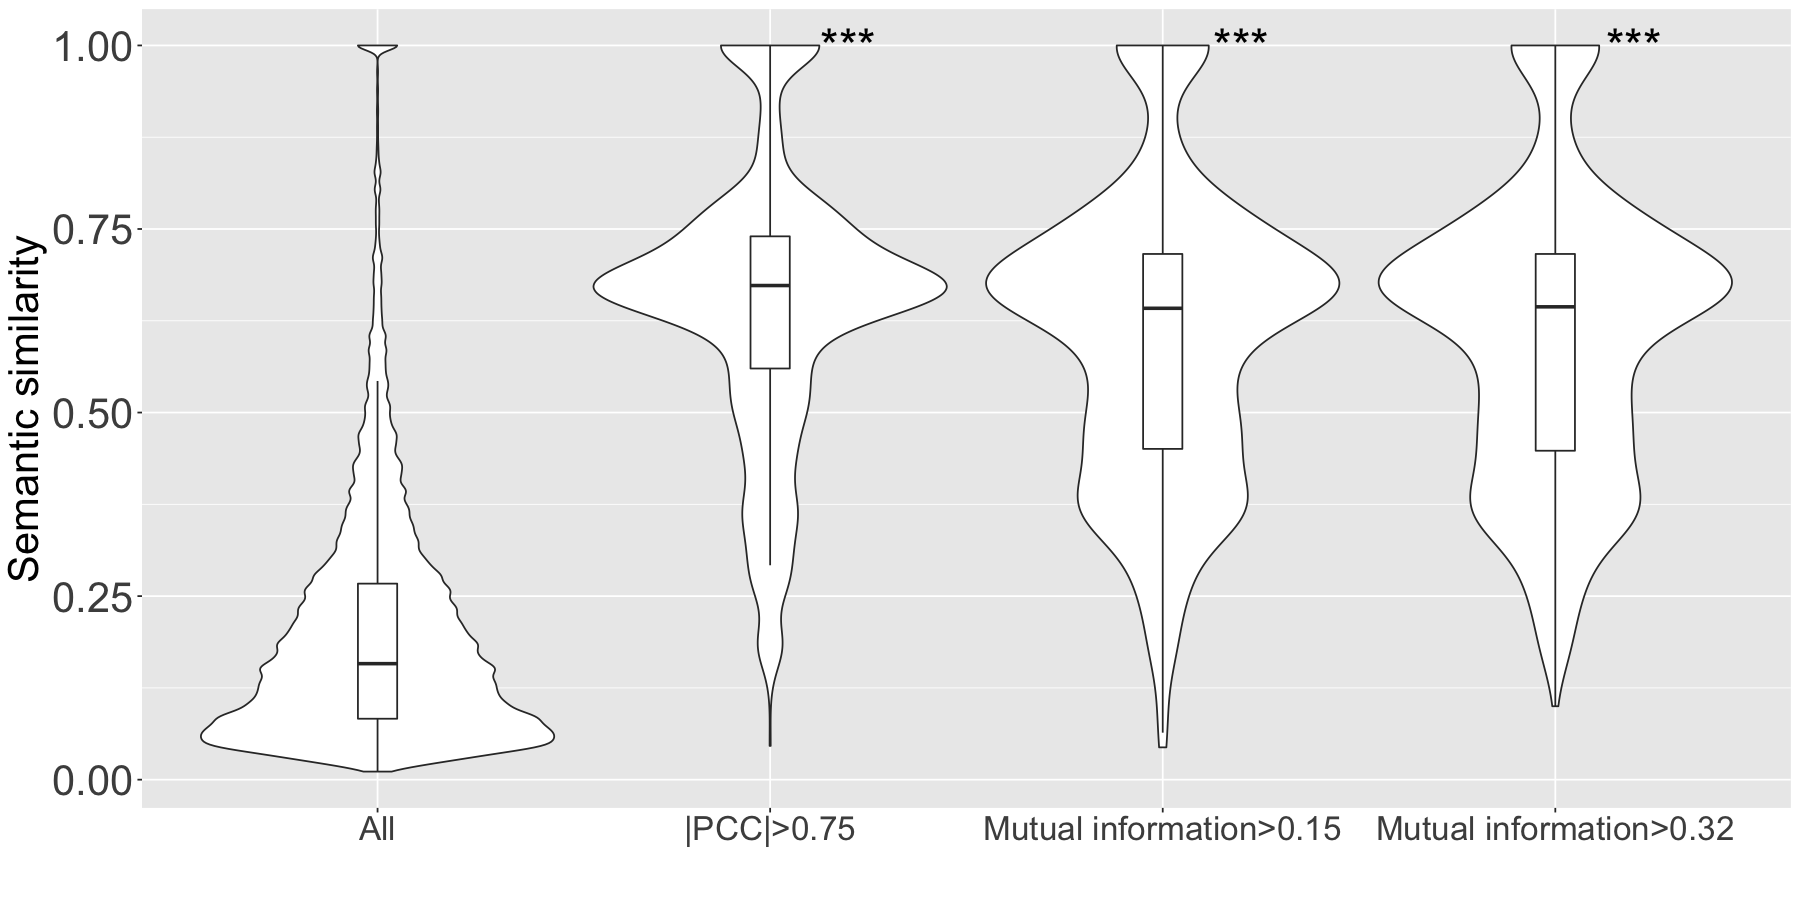

In [36]:
#GO violin using the same similarity cutoffs

load("Data/strain1_strain2_WangBPnoIEA.RData") #this file was generated by GO_with_without_IEA.R

#remove pairs that don't have semantic similarity; change class of strains from chr to numeric
strain1_strain2_WangBPnoIEA=strain1_strain2_WangBPnoIEA[!is.na(strain1_strain2_WangBPnoIEA$BP),]
strain1_strain2_WangBPnoIEA$strain1=as.numeric(strain1_strain2_WangBPnoIEA$strain1)
strain1_strain2_WangBPnoIEA$strain2=as.numeric(strain1_strain2_WangBPnoIEA$strain2)

strain1strain2_allAnnotations_allDistances_WangBPnoIEA=left_join(strain1_strain2_WangBPnoIEA,strain1strain2_allAnnotations_allDistances,by=c("strain1","strain2"))
names(strain1strain2_allAnnotations_allDistances_WangBPnoIEA)[3]="BPnoNA"


#Violin using GO annotations


options(repr.plot.width = 15, repr.plot.height = 15/2)

#get p5+p6
xlabs=c("All","|PCC|>0.75","Mutual information>0.15","Mutual information>0.32")

##cutoff index for pairs that have pcc>0.75
cuoff_index_pcc=sum((1-strain1strain2_allAnnotations_allDistances_WangBPnoIEA$pcc)>0.75)
cuoff_index_mi_1=sum((1-strain1strain2_allAnnotations_allDistances_WangBPnoIEA$mi_ternary)>0.15)
cuoff_index_mi_2=sum((1-strain1strain2_allAnnotations_allDistances_WangBPnoIEA$mi_ternary_collapsedCond)>0.32)
##note: no need to sort because I used sum()


df=strain1strain2_allAnnotations_allDistances_WangBPnoIEA


##the first box
#------------------------------------------------
box1=df$BPnoNA[!is.na(df$BPnoNA)]
#------------------------------------------------

##the second box
#------------------------------------------------
similarity="pcc"
box2=df$BPnoNA[order(df[[similarity]])][1:cuoff_index_pcc]
box2=box2[!is.na(box2)]
#------------------------------------------------

##the third box
#------------------------------------------------
similarity="mi_ternary"
box3=df$BPnoNA[order(df[[similarity]])][1:cuoff_index_mi_1]
box3=box3[!is.na(box3)]
#------------------------------------------------

##the forth box
#------------------------------------------------
similarity="mi_ternary_collapsedCond"
box4=df$BPnoNA[order(df[[similarity]])][1:cuoff_index_mi_2]
box4=box4[!is.na(box4)]
#------------------------------------------------


df_all=data.frame(All=box1)
df1=data.frame(aboveCutoff1=box2)
df2=data.frame(aboveCutoff2=box3)
df3=data.frame(aboveCutoff3=box4)


p7=ggplot() +
  geom_violin(data = df_all,aes(xlabs[1],All)) +
  geom_boxplot(data = df_all,aes(xlabs[1],All),width=0.1,outlier.shape = NA)+ #outlier.shape decides the shape of outliers. Here I don't let them show
  geom_violin(data = df1,aes(xlabs[2],aboveCutoff1)) +
  geom_boxplot(data = df1,aes(xlabs[2],aboveCutoff1),width=0.1,outlier.shape = NA)+
  geom_violin(data = df2,aes(xlabs[3],aboveCutoff2)) +
  geom_boxplot(data = df2,aes(xlabs[3],aboveCutoff2),width=0.1,outlier.shape = NA)+
  geom_violin(data = df3,aes(xlabs[4],aboveCutoff3)) +
  geom_boxplot(data = df3,aes(xlabs[4],aboveCutoff3),width=0.1,outlier.shape = NA)+
  scale_x_discrete("",limits=xlabs)+ 
  #I want the x axis to be empty. And if I don't use this, the order is not right
  scale_y_continuous("Semantic similarity")+
  theme(text=element_text(size=25), 
        axis.text.y=element_text(size=25),
        axis.title=element_text(size=25))

p7+
  annotate(geom="text", x=2.2, y=1, label="***",color="black",size=10)+
  annotate(geom="text", x=3.2, y=1, label="***",color="black",size=10)+
  annotate(geom="text", x=4.2, y=1, label="***",color="black",size=10)





In [37]:
#significance test
wilcox.test(box2,box1,alternative="greater") #p-value < 2.2e-16
wilcox.test(box3,box1,alternative="greater") #p-value < 2.2e-16
wilcox.test(box4,box1,alternative="greater") #p-value < 2.2e-16


	Wilcoxon rank sum test with continuity correction

data:  box2 and box1
W = 2904319464, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  box3 and box1
W = 3389641664, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  box4 and box1
W = 2966729906, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0


# Figure S6

In [11]:
subset=5000

#functions to get confusion matrix based on annot and similarity
get_confusionMatrix=function(table_,annot,similarity,seed=123){   
    df=table_[,c(annot,similarity)]
        if(length(annot)>=2){
            coannotation=(rowSums(df[,annot])>=1)
            #coannotation=(rowSums(df[,annot])>=length(annot)) this is A&B&...
            cumsum_=cumsum(coannotation[order(df[,similarity],decreasing=T)])
            return(confusionMatrix_metrics(cumsum_,seed=seed))
        } 
    
    cumsum_=cumsum(df[,annot][order(df[,similarity],decreasing=T)])
    return(confusionMatrix_metrics(cumsum_,seed=seed))
}

In [27]:
#generate result of binary classification problem, a sql table (remember to keep track of the original id)
load("Data/uniqueChemIndex.RData")
TF=( names(uniqueChemIndex) %in% c("NH4Cl (MOPS)","Iron excess-FeSO4","Iron starvation-FeSO4","Acetate (M9)",
                                   "Glucosamine (M9)","Glucose (M9)","Glycerol (M9)","Maltose (M9)","N-acetyl Glucosamine","Succinate (M9)") )
used_cond=names(uniqueChemIndex)[!TF]
cond_indices=unlist(uniqueChemIndex[used_cond])

#experiments:

##do corr VS annot excluding the minial media condition

##(I suspect this will give us a better result. There are only 10 minimal media conditions out of 324 conditions)

##correlate genes only based on the minimal media condition

#(!)Need to add mi, spearman, ternary_mi for non minimal media only

cor_matrix=cor(t(All_Data_NAimputed[,cond_indices])) ##warning: sd is 0 => might be scores for some strains are all 0
##anyIncomplete(cor_matrix) #verify that NAs have been generated
cor_matrix[is.na(cor_matrix)]=-9 #change where cor=NA to -9 
dist_=as.dist(cor_matrix)
new_cor_table=meltANDsort_dist(dist_)
new_cor_table=new_cor_table[!(new_cor_table[,3]==-9),] 
new_cor_table$object_1=as.numeric(new_cor_table$object_1)
new_cor_table$object_2=as.numeric(new_cor_table$object_2)
new_cor_table[,3]=abs(new_cor_table[,3]) #change pcc to pcc based distance
names(new_cor_table)[1:2]=c("strain1","strain2")

##===output pcc table===================================================
#currentDir=dirname(rstudioapi::getActiveDocumentContext()$path)
#png(filename=paste(currentDir,"_no_minimal_cor.png",sep="/"))
#hist(new_cor_table[,3],xlab="PCC",main="")
#dev.off()
#=======================================================================

##calculate cumsum based on pcc

table_1=strain1strain2_allAnnotations_allSimilarities
table_1$abs_pcc=abs(table_1$pcc)
load("Data/strain1strain2_allSimilarities_noMinimalMedia.RData")
table_2=left_join(strain1strain2_allSimilarities_noMinimalMedia,strain1strain2_allAnnotations_allSimilarities[,1:7],by=c("strain1","strain2"))
table_2$abs_pcc=abs(table_2$pcc)

In [28]:
graph_pr=function(metric_,similarity_,cols,ylim,lwd,annot_list,annot_list_name){
    
options(repr.plot.width = 10, repr.plot.height = 7)    
        
          for(j in seq(annot_list)){
  
          #precalculate and subset to prevent memory problem
          con1=get_confusionMatrix(table_=table_1[order(table_1$abs_pcc,decreasing=T)[1:5000],],annot_list[[j]],similarity_,seed=103)
          con2=get_confusionMatrix(table_=table_2[order(table_1$abs_pcc,decreasing=T)[1:5000],],annot_list[[j]],similarity_,seed=103)


          exp_list=list(con1,con2)
          exp_1_name="All conditions"
          exp_2_name="Without minimal media"
          names(exp_list)=c(exp_1_name,exp_2_name)



          for(i in seq(exp_list)){
            if(i==1){
                                                  
              plot(exp_list[[i]]$sensitivity,
                   exp_list[[i]][[metric_]],
                   xlab="",ylab="",type='l',col=cols[i],
                   ylim=ylim,lwd = lwd,main=paste0("Same ",paste(annot_list_name[j],collapse=" "))) 
              grid(lty='solid')

                
            }else{
              lines(exp_list[[i]]$sensitivity,
                    exp_list[[i]][[metric_]],
                    col=cols[i],lwd = lwd) 
            }

              
              
              #add points for 250th, 500th pairs
              
              ##c_adj_position=0
              ##if(i==2) c_adj_position=0.05
              
              x=exp_list[[i]]$sensitivity[500]
              y=exp_list[[i]]$precision[500]
              y1=exp_list[[i]]$precision[500]+0.15/2 
              ##text(x=x+c_adj_position,y=y1,label="500th")
              points(x,y,pch=1,col=cols[i],cex=2)
              
              x=exp_list[[i]]$sensitivity[250]
              y=exp_list[[i]]$precision[250]
              y1=exp_list[[i]]$precision[250]+0.15/2 
              ##text(x=x+c_adj_position,y=y1,label="250th")
              points(x,y,pch=1,col=cols[i],cex=2)
              
              
              
              
          }

          legend(0.4, 1.04, legend=names(exp_list),
                 col=cols, lty=1,lwd = lwd, cex=1, box.lty=0) 

          #add the negative control
          set.seed(123)
          index=sample(dim(table_1)[1],5000)
          random_coannotation=table_1[index,annot_list[[j]]]
              
          if(length(annot_list[[j]])!=1){ #if there are more than 1 co-annotation, take the union
            random_coannotation=ifelse(rowSums(random_coannotation)>=1,1,0)
          }  
                      
          random_sensitivity=cumsum(random_coannotation)/sum(random_coannotation)
          random_precision=cumsum(random_coannotation)/seq(random_coannotation)
          lines(random_sensitivity,random_precision,lty = 'dotted',lwd=2.5) 
    
          #cat(str(random_precision),'\n')
              

}
}

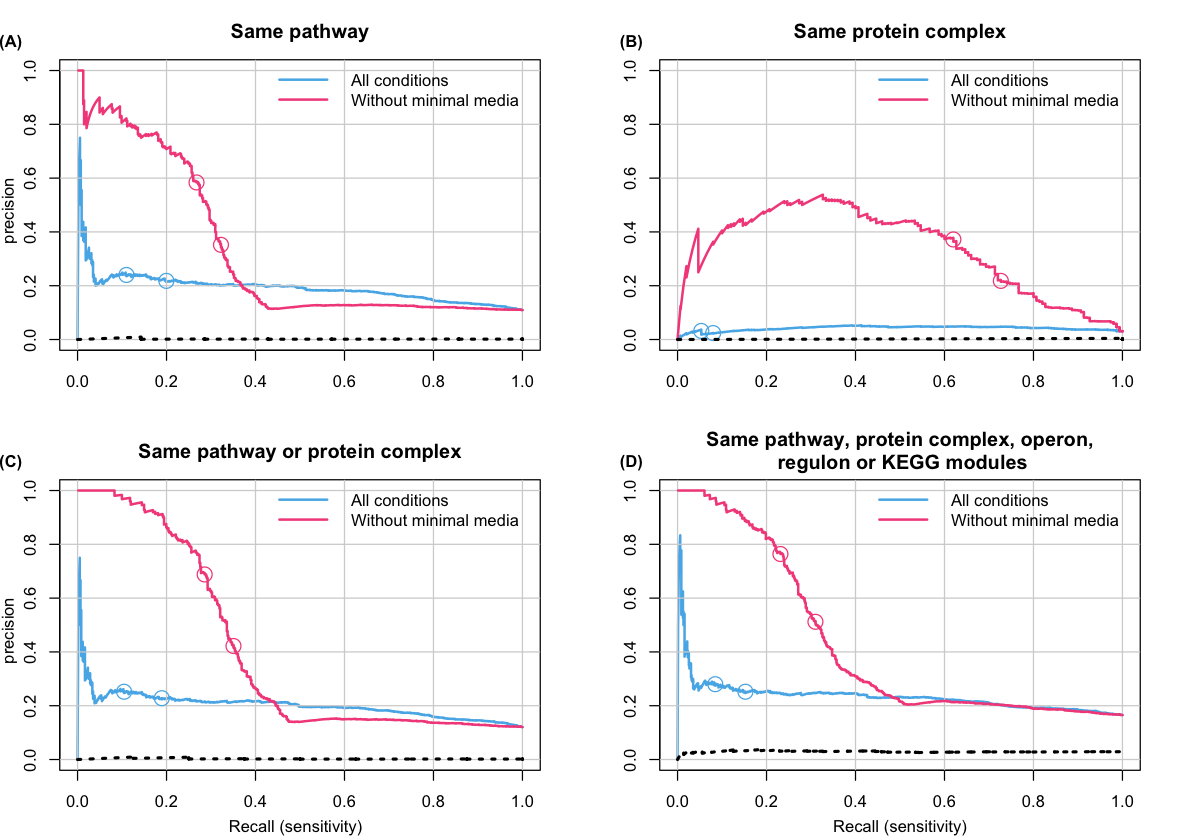

In [29]:
metric="precision" #this is a highly imbalanced dataset so I will not use accuracy or specificity
similarity="pcc"
cols=c("#56B4E9","#F3518A")
y=metric
ylim=c(0,1)
lwd=2
annot_list=list("pwy","pcomplex",c("pwy","pcomplex"),c("pwy","pcomplex","operon","regulon","kegg_modules"))
annot_list_name=c("pathway","protein complex",
                  "pathway or protein complex",
                  "pathway, protein complex, operon,\n regulon or KEGG modules"
                 )

par(mfrow=c(2,2),mar=c(3.5,3,3,3),oma=c(0,0,0,0))
graph_pr(metric,similarity,cols,ylim,lwd,annot_list,annot_list_name)

## add x and y-axis (https://stackoverflow.com/questions/11198767/how-to-annotate-across-or-between-plots-in-multi-plot-panels-in-r)
text(grconvertX(.087, "ndc", "user"), grconvertY(.75, "ndc", "user"), "precision", srt=90, xpd=NA)
text(grconvertX(.087, "ndc", "user"), grconvertY(.25, "ndc", "user"), "precision", srt=90, xpd=NA)
text(grconvertX(0.3, "ndc", "user"), grconvertY(0.015, "ndc", "user"), "Recall (sensitivity)", xpd=NA)
text(grconvertX(0.75, "ndc", "user"), grconvertY(0.015, "ndc", "user"), "Recall (sensitivity)", xpd=NA)

# add (A), (B), (C), (D)
text(grconvertX(.088, "ndc", "user"), grconvertY(0.95, "ndc", "user"), "(A)", xpd=NA,font=2)
text(grconvertX(.55, "ndc", "user"), grconvertY(0.95, "ndc", "user"), "(B)", xpd=NA,font=2)
text(grconvertX(.088, "ndc", "user"), grconvertY(0.45, "ndc", "user"), "(C)", xpd=NA,font=2)
text(grconvertX(.55, "ndc", "user"), grconvertY(0.45, "ndc", "user"), "(D)", xpd=NA,font=2)

In [30]:
#AUC: sum(d_sensitivity * precision ) 

calculate_auc=function(con){
    i=2:dim(con)[1]
    d_sensitivity=con$sensitivity[i]-con$sensitivity[i-1]
    precision=con$precision[i]
    
    auc_=sum(d_sensitivity*precision)
    
    return(auc_)
}


calculate_random_auc=function(con){
    i=2:dim(con)[1]
    d_sensitivity=con$random_sensitivity[i]-con$random_sensitivity[i-1]
    precision=con$random_precision[i]
    
    auc_=sum(d_sensitivity*precision)
    
    return(auc_)
}


print("from left to right: with minimal media, no minimal media, random")

similarity_="pcc"

for(j in seq(annot_list)){
    
  subset=5000
  con1=get_confusionMatrix(table_=table_1[order(table_1$abs_pcc,decreasing=T)[1:subset],],annot_list[[j]],similarity_,seed=103)
  con2=get_confusionMatrix(table_=table_2[order(table_2$abs_pcc,decreasing=T)[1:subset],],annot_list[[j]],similarity_,seed=103)
    
 
  cat(paste("AUC for",paste(annot_list[[j]],collapse=", "),"is: "))  
    
  calculate_auc(con1) %>% cat
  cat(" ")
  calculate_auc(con2) %>% cat
  cat(" ")
  calculate_random_auc(con1) %>% cat
  cat(" ")
    
  cat("\n")  
}

[1] "from left to right: with minimal media, no minimal media, random"
AUC for pwy is: 0.1928179 0.5021288 0.1053878 
AUC for pcomplex is: 0.04183998 0.305948 0.02980675 
AUC for pwy, pcomplex is: 0.2031477 0.5676364 0.1162944 
AUC for pwy, pcomplex, operon, regulon, kegg_modules is: 0.2352434 0.472415 0.1590447 


# Figure S7

In [32]:
## without minimal media
con1=get_confusionMatrix(table_2[order(table_2$abs_pcc,decreasing=T)[1:subset],],c("pwy","pcomplex","operon","regulon","kegg_modules"),"pcc",seed=1009)[1:subset,]
con2=get_confusionMatrix(table_2[order(table_2$abs_pcc,decreasing=T)[1:subset],],c("pwy","pcomplex","operon","regulon","kegg_modules"),"mi",seed=1009)[1:subset,]
con3=get_confusionMatrix(table_2[order(table_2$abs_pcc,decreasing=T)[1:subset],],c("pwy","pcomplex","operon","regulon","kegg_modules"),"spearman",seed=1009)[1:subset,]

annot_list=list(con1,con2,con3)
names(annot_list)=c("PCC","MI","Spearman")

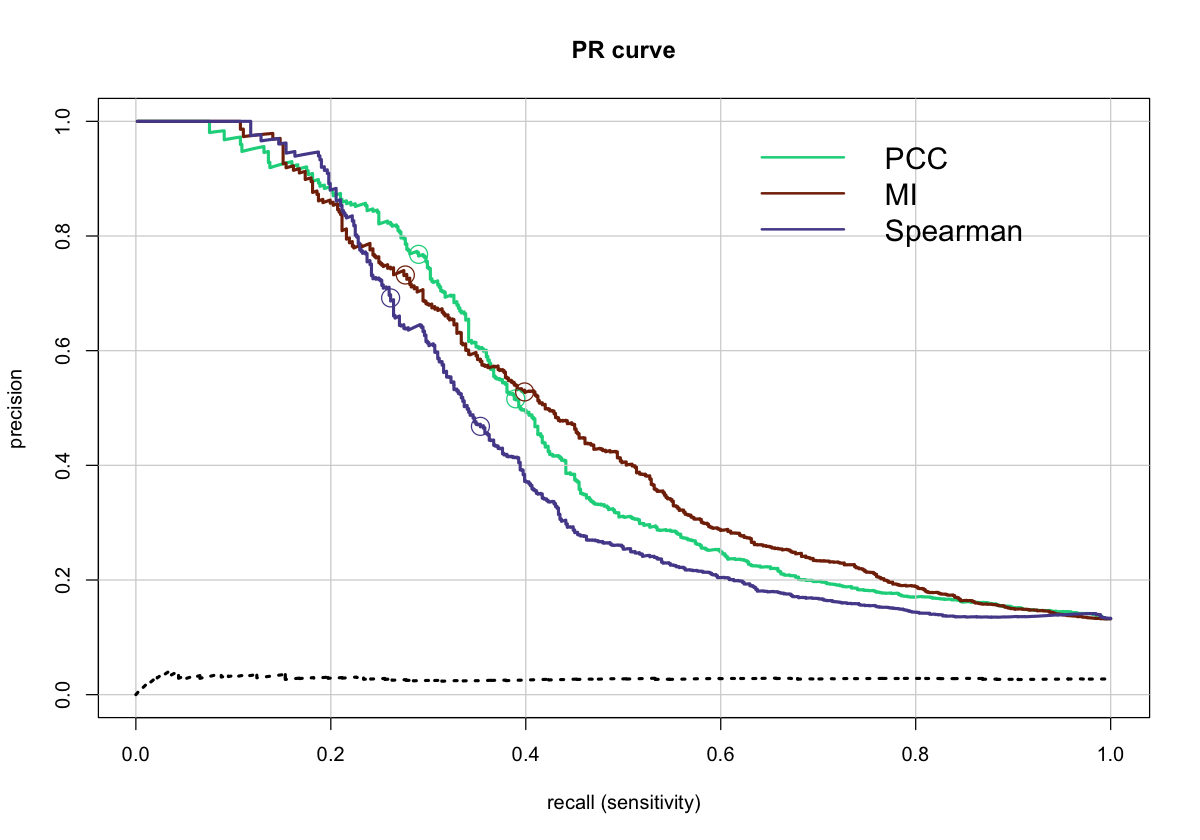

In [33]:
#Complete PR curve

cols=c("#09D38A","#832B05","#564c99")
plot(annot_list[[1]]$sensitivity,
     annot_list[[1]]$precision,
     type="l",xlab="recall (sensitivity)",ylab="precision",main="PR curve",col=cols[1],lwd=2.5,ylim=c(0,1))

     grid(lty='solid')

for(i in 2:3){
    lines(annot_list[[i]]$sensitivity,annot_list[[i]]$precision,col=cols[i],lwd=2.5,ylim=c(0,1))
}



for(i in seq(annot_list)){
    #add points for 250th, 500th pairs          
    x=annot_list[[i]]$sensitivity[500]
    y=annot_list[[i]]$precision[500]
    y1=annot_list[[i]]$precision[500]+0.15/2 
    points(x,y,pch=1,col=cols[i],cex=2)
    
    x=annot_list[[i]]$sensitivity[250]
    y=annot_list[[i]]$precision[250]
    y1=annot_list[[i]]$precision[250]+0.15/2 
    points(x,y,pch=1,col=cols[i],cex=2)
    
}
              
              



legend(.6, 1, legend=names(annot_list),
       col=cols, lty=1,lwd = lwd, cex=1.5, box.lty=0) #box.lty=0 removes the legend border  

#add the negative control
set.seed(104)
index=sample(dim(table_1)[1],5000)
random_coannotation=rowSums(table_1[index,c("pwy","pcomplex","operon","regulon","kegg_modules")])              
random_sensitivity=cumsum(random_coannotation)/sum(random_coannotation)
random_precision=cumsum(random_coannotation)/seq(random_coannotation)
 
lines(random_sensitivity,random_precision,col='black',lty = 'dotted',lwd=2.5)

# Figure S8

In [34]:
#This gets precison using the same combination of annotations as the violin plots
subset=5000

#precalculate and subset to prevent memory problem
con1=get_confusionMatrix(table_1[order(table_1$abs_pcc,decreasing=T)[1:subset],],c("pwy","pcomplex","operon","regulon","kegg_modules"),"mi",seed=1009)[1:subset,]
con2=get_confusionMatrix(table_1[order(table_1$abs_pcc,decreasing=T)[1:subset],],c("pwy","pcomplex","operon","regulon","kegg_modules"),"mi_ternary",seed=1009)[1:subset,]
con3=get_confusionMatrix(table_1[order(table_1$abs_pcc,decreasing=T)[1:subset],],c("pwy","pcomplex","operon","regulon","kegg_modules"),"mi_ternary_collapsedCond",seed=1009)[1:subset,]


annot_list=list(con1,con2,con3)
names(annot_list)=c("MI","MI on ternary data","MI on ternary data - Conditions collapsed")

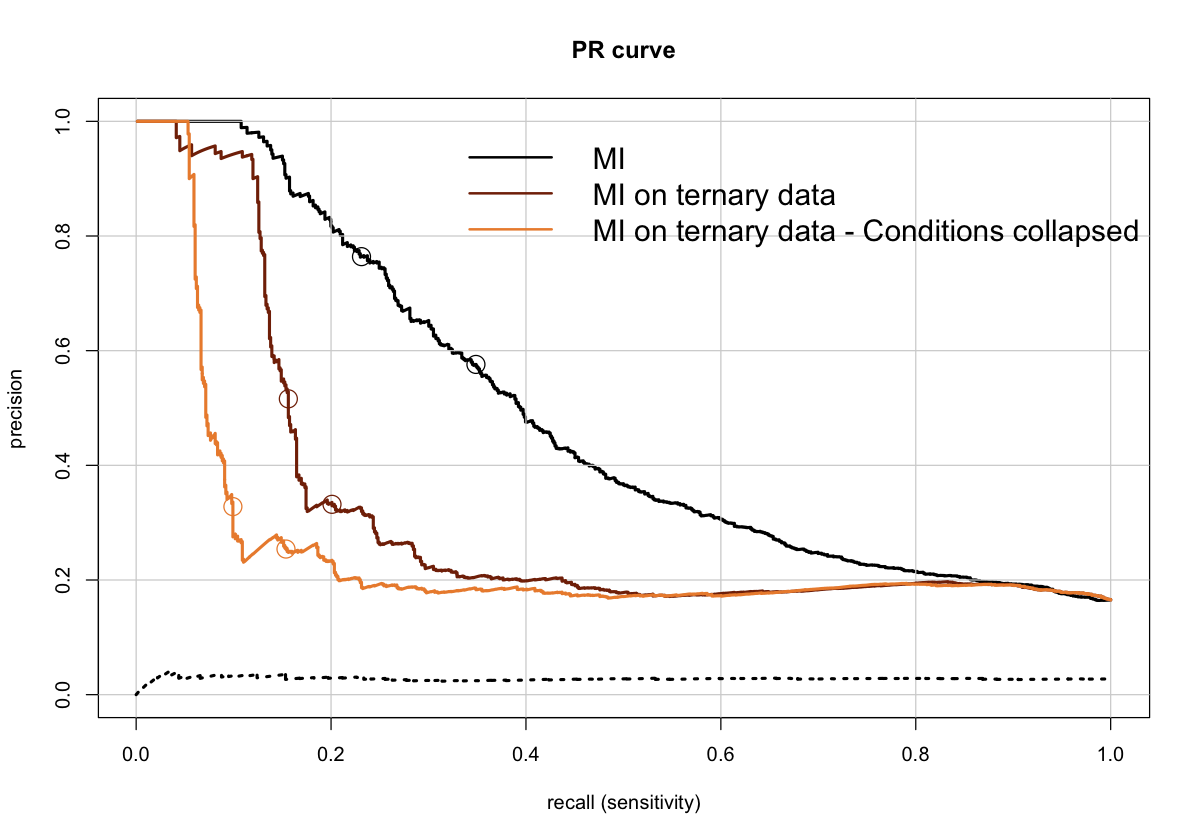

In [35]:
#Complete PR curve

cols=c("black","#832B05","#EC8D3A")
plot(annot_list[[1]]$sensitivity,
     annot_list[[1]]$precision,
     type="l",xlab="recall (sensitivity)",ylab="precision",main="PR curve",col=cols[1],lwd=2.5,ylim=c(0,1))
     
     grid(lty='solid')

for(i in 2:3){
    lines(annot_list[[i]]$sensitivity,annot_list[[i]]$precision,col=cols[i],lwd=2.5,ylim=c(0,1))
}


for(i in seq(annot_list)){
    #add points for 250th, 500th pairs          
    x=annot_list[[i]]$sensitivity[500]
    y=annot_list[[i]]$precision[500]
    y1=annot_list[[i]]$precision[500]+0.15/2 
    points(x,y,pch=1,col=cols[i],cex=2)
    
    x=annot_list[[i]]$sensitivity[250]
    y=annot_list[[i]]$precision[250]
    y1=annot_list[[i]]$precision[250]+0.15/2 
    points(x,y,pch=1,col=cols[i],cex=2)
}



legend(.3, 1, legend=names(annot_list),
       col=cols, lty=1,lwd = lwd, cex=1.5, box.lty=0) #box.lty=0 removes the legend border 

#add the negative control
set.seed(104)
index=sample(dim(table_1)[1],5000)
random_coannotation=rowSums(table_1[index,c("pwy","pcomplex","operon","regulon","kegg_modules")])              
random_sensitivity=cumsum(random_coannotation)/sum(random_coannotation)
random_precision=cumsum(random_coannotation)/seq(random_coannotation)
 
lines(random_sensitivity,random_precision,col='black',lty = 'dotted',lwd=2.5)